# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Ход проекта

* **Знакомство с данными**
* **Предообработка данных**
* **Подготовка данных**
* **Обучение моделей**
* **Тестирование лучшей модели**
* **Вывод**

## Знакомство с данными.

In [7]:
import pandas as pd
import warnings
import numpy as np
import os
import nltk
import re
import lightgbm as lgb
import seaborn as sns
import spacy
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.pipeline import Pipeline


nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
f1 = make_scorer(f1_score , average='macro')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bezth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
pth1 = 'C:/Users/bezth/datasets/toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=0)
    print('complete')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=0)
else:
    print('Something is wrong')

complete


In [10]:
print(data.info())
print()
print(data.shape)
print()
print(data.isna().sum())
print()
print(data.duplicated().sum())
print()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None

(159292, 2)

text     0
toxic    0
dtype: int64

0



,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


**Всё в порядке, только один лишний столбец повторяющий индексацию.**

In [11]:
data.tail()

,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


**Интересно то что индексация второго столбца где-то сбивается**

In [12]:
data['toxic'].sum()

16186

In [13]:
data['toxic'].sum()/data['toxic'].count()

0.10161213369158527

**10% твитов - токсичны.**

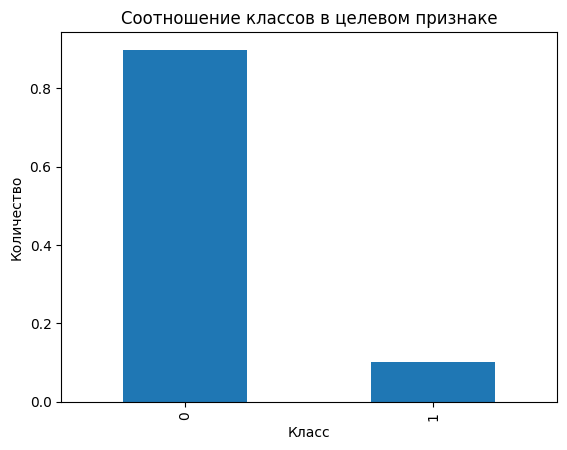

In [14]:
class_frequency = data['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar', title='Соотношение классов в целевом признаке', xlabel='Класс', ylabel='Количество');

### Промежуточный вывод

* **С данными полный порядок, пропусков нет, дубликатов нет, тип данных, назвния колонок - порядок.**
* **Данные содердат 160тысяч строк и 3 столбца.**
* **В таблице лишний столбец с битыми индексами.**

## Подготовка

In [16]:
data['text'].head(10)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
5    "\n\nCongratulations from me as well, use the ...
6         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7    Your vandalism to the Matt Shirvington article...
8    Sorry if the word 'nonsense' was offensive to ...
9    alignment on this subject and which are contra...
Name: text, dtype: object

In [17]:
%%time
lemm_text = []
for i in data['text']:
    text = re.sub(r'[^a-zA-Z]', " ", i.lower()).split()    
    wordsFiltered = [w for w in text if w not in stopwords]
    text = ' '.join(wordsFiltered)
    doc = nlp(text)
    
    lemm_text.append(" ".join([token.lemma_ for token in doc]))

CPU times: total: 18min 3s
Wall time: 20min 35s


In [18]:
data['text'] = lemm_text    
data['text'].head(10)

0    explanation edit make username hardcore metall...
1    aww match background colour seemingly stuck th...
2    hey man really try edit war guy constantly rem...
3    make real suggestion improvement wonder sectio...
4                        sir hero chance remember page
5               congratulation well use tool well talk
6                          cocksucker piss around work
7    vandalism matt shirvington article reverted pl...
8    sorry word nonsense offensive anyway intend wr...
9                 alignment subject contrary dulithgow
Name: text, dtype: object

In [19]:
data.head()

,text,toxic
0,explanation edit make username hardcore metall...,0
1,aww match background colour seemingly stuck th...,0
2,hey man really try edit war guy constantly rem...,0
3,make real suggestion improvement wonder sectio...,0
4,sir hero chance remember page,0


In [20]:
neg = data.loc[data['toxic'] == 1]
pos = data.loc[data['toxic'] == 0]

In [21]:
neg_txt = (' '.join(neg['text'].tolist())).split()
pos_txt = (' '.join(pos['text'].tolist())).split()

In [22]:
fdist = FreqDist(neg_txt)
fdist_p = FreqDist(pos_txt)


In [23]:
fdist.most_common(20)

[('fuck', 10563),
 ('suck', 4813),
 ('go', 4190),
 ('like', 3946),
 ('wikipedia', 3929),
 ('shit', 3719),
 ('nigger', 3421),
 ('get', 3335),
 ('ass', 3031),
 ('fucking', 2962),
 ('u', 2946),
 ('page', 2857),
 ('hate', 2774),
 ('faggot', 2704),
 ('know', 2692),
 ('bitch', 2339),
 ('gay', 2289),
 ('edit', 2262),
 ('die', 2240),
 ('make', 2218)]

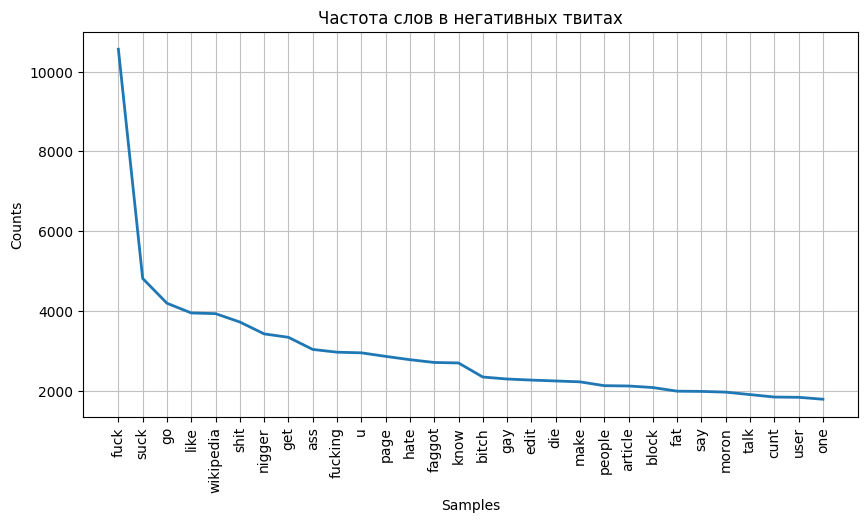

In [25]:
plt.figure(figsize=(10, 5))
plt.title('Частота слов в негативных твитах')
fdist.plot(30, cumulative=False);

In [26]:
fdist_p.most_common(20)

[('article', 71994),
 ('page', 54233),
 ('wikipedia', 44648),
 ('talk', 38439),
 ('edit', 34256),
 ('use', 31923),
 ('one', 28881),
 ('please', 28786),
 ('would', 28168),
 ('make', 28057),
 ('see', 25637),
 ('like', 24692),
 ('say', 23336),
 ('source', 22893),
 ('think', 22856),
 ('thank', 22584),
 ('know', 21382),
 ('also', 19750),
 ('well', 19388),
 ('add', 19082)]

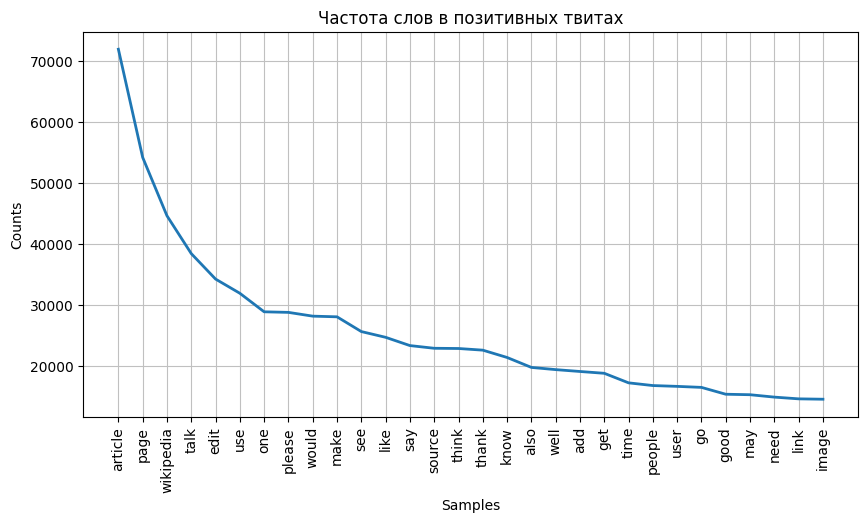

In [27]:
plt.figure(figsize=(10, 5))
plt.title('Частота слов в позитивных твитах')
fdist_p.plot(30, cumulative=False);

### Разделение выборки, TF-IDF векторизация.

In [29]:
features = data.drop('toxic', axis=1)
target = data['toxic']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target)

In [31]:
corpus_train = X_train['text'].values

In [32]:
corpus_test = X_test['text'].values

In [33]:
%%time
count_tf_idf = TfidfVectorizer(stop_words = stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # Фитим на трейне.
tf_idf_train.shape

tf_idf_test = count_tf_idf.transform(corpus_test) # Трансформим тест.
tf_idf_test.shape

CPU times: total: 4.36 s
Wall time: 5.42 s


(39823, 129731)

%%time
count_tf_idf = TfidfVectorizer(stop_words = stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train['text']) # Фитим на трейне.
tf_idf_train.shape

tf_idf_test = count_tf_idf.transform(X_test['text']) # Трансформим тест.
tf_idf_test.shape

In [34]:
tf_idf_train

<119469x129731 sparse matrix of type '<class 'numpy.float64'>'
	with 3135443 stored elements in Compressed Sparse Row format>

### Промежуточный вывод

* **На мощностях яндекса или моего бука лемматизация текста выглядит сомнительным движением, в принципе можно было-бы и запустить, но ~35 часов это такое себе.**
* **Выборка разделенны на трейн и тест, выполнена TF-IDF векторизация текста.**

## Обучение моделей

### LogisticRegression

In [35]:
tf_idf_pip = TfidfVectorizer(stop_words = stopwords)

In [36]:
X_train = X_train.iloc[:, 0]

In [37]:
X_test = X_test.iloc[:, 0]

In [38]:
%%time
model_lr = LogisticRegression(random_state = 42)

final_pipe = Pipeline([('tfidf', tf_idf_pip),
                       ('model', model_lr)])

params = {
    'model__C': [1, 5, 10, 20],
}

grid_lr = GridSearchCV(final_pipe, param_grid = params, cv=3, scoring=f1)

grid_lr.fit(X_train, y_train)

CPU times: total: 51.7 s
Wall time: 1min 22s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    'can',
                                                                    'couldn',
                                                                    "couldn't", ...})),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'model__C': [1, 5, 10, 20]},
             scoring=make_scorer(f1_score, average=macro))

In [39]:
print('Лучшие гиперпараметры модели')
print(grid_lr.best_params_)

print('score:')
print('LogisticRegression f1_score:', grid_lr.best_score_)

Лучшие гиперпараметры модели
{'model__C': 10}
score:
LogisticRegression f1_score: 0.8762474135152623


In [40]:
%%time
pred_lr = grid_lr.predict(X_train)

CPU times: total: 3.34 s
Wall time: 3.88 s


**Время обучения LogisticRegression 3.34 секунды, время предсказания 47мс. f1_score 0.75**

### LightGBM Classifier

In [41]:
%%time
model_lg = LGBMClassifier()

final_pipe = Pipeline([('tfidf', tf_idf_pip),
                       ('model', model_lg)])

params = {
    'model__num_leaves': [45],
    'model__learning_rate': [0.5],
    'model__max_depth': [None],
    'model__n_estimators': [15],
    'model__random_state': [42],
    'model__num_iterations': [25],
}

grid_light = GridSearchCV(final_pipe, param_grid = params, cv=3, scoring=f1)

grid_light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.816398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387738
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7470
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101612 -> initscore=-2.179439
[LightGBM] [Info] Start training from score -2.179439
[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.816837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385470
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7425
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101612 -> initscore=-2.179

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    'can',
                                                                    'couldn',
                                                                    "couldn't", ...})),
                                       ('model', LGBMClassifier())]),
             param_grid={'model__learning_rate': [0.5],
                         'model__max_depth': [None],
                         'model__n_estimators': [15],
                         'model__num_iterations': [25],
                         'model__num_leaves': [45],
                         'model__random_state': [42]},
             scoring=make_scorer(f1_score, average=macro))

**Запускал через поиски параметров, мелкими диапозонами, а потом и вовсе точечными. Оставил так что-бы время не тратила.**

In [42]:
print('Лучшие гиперпараметры модели')
print(grid_light.best_params_)

print('score:')
print('LGBMRClassifier f1_score:', grid_light.best_score_)

Лучшие гиперпараметры модели
{'model__learning_rate': 0.5, 'model__max_depth': None, 'model__n_estimators': 15, 'model__num_iterations': 25, 'model__num_leaves': 45, 'model__random_state': 42}
score:
LGBMRClassifier f1_score: 0.8708476595356158


**LightGBM Classifier - время кроссвалидации 43 секунды, время обучения 14.5 сек, время предсказания 0.5 сек. f1_score: 0.86**

### PassiveAgressiveClassifier

In [43]:
%%time
model_pac = PassiveAggressiveClassifier(n_jobs=-1, random_state=42)

final_pipe = Pipeline([('tfidf', tf_idf_pip),
                       ('model', model_pac)])

params = {
    'model__max_iter': [50, 100],
    'model__C': [5, 10, 20],
}

grid_pac = GridSearchCV(final_pipe, param_grid = params, cv=3, scoring=f1)

grid_pac.fit(X_train, y_train)

CPU times: total: 1min 24s
Wall time: 1min 34s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
                                                                    "aren't",
                                                                    'as', 'at',
                                                                    'be',
                                                                    'because',
                                                                    'been',
                                                                    'before',
                                                                    'being',
                                                                    'below',
                                                                    'between',
                                                                    'both',
                                                                    'but', 'by',
                                                                    'can',
                                                                    'couldn',
                                                                    "couldn't", ...})),
                                       ('model',
                                        PassiveAggressiveClassifier(n_jobs=-1,
                                                                    random_state=42))]),
             param_grid={'model__C': [5, 10, 20], 'model__max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=macro))

In [44]:
print('Лучшие гиперпараметры модели')
print(grid_pac.best_params_)

print('score:')
print('PassiveAgressiveClassifier f1_score:', grid_pac.best_score_)

Лучшие гиперпараметры модели
{'model__C': 5, 'model__max_iter': 50}
score:
PassiveAgressiveClassifier f1_score: 0.8537559861789767


In [45]:
%%time
predp = grid_pac.predict(X_train)

CPU times: total: 3.25 s
Wall time: 3.93 s


**PassiveAgressiveClassifier - время кроссвалидации 15 секунд, время обучения 1 сек, время предсказания 1 сек. f1_score: 0.47**

### Промежуточный вывод

* **Обучили три модели - RandomForestRegressor, LightGBM Classifier, RandomForestClassifier.**
* **Модели показали следующие результаты**
* **LogisticRegression время обучения 3.34 секунды, время предсказания 47мс. f1_score: 0.75**
* **LightGBM Classifier - время кроссвалидации 43 секунды, время обучения 14.5 сек, время предсказания 0.5 сек. f1_score: 0.86**
* **RandomForestClassifier - время кроссвалидации 15 секунд, время обучения 1 сек, время предсказания 1 сек. f1_score: 0.47**
* **По итоговым результатам скорости обучения и значения f1 метрики выбрали LGBMClassifier как лучшую модель.**

## Тестирование лучшей модели.

In [46]:
%%time
predictions = grid_lr.predict(X_test)

CPU times: total: 1.02 s
Wall time: 1.31 s


In [47]:
print(f1_score(predictions, y_test))

0.7757859900717042


**На тестовой выборке лучшая модель показала время обучения 0.2 сек, показатель f1 0.75**

### Проверка дамми

In [48]:
dummy = DummyClassifier(strategy = 'constant', constant = 1)
dummy.fit(tf_idf_train, y_train)
predictions = dummy.predict(X_test)
print(f1_score(predictions, y_test))

0.18445827349609065


## Выводы

### Знакомство с данными

* **С данными полный порядок, пропусков нет, дубликатов нет, тип данных, назвния колонок - порядок.**
* **Данные содердат 160тысяч строк и 3 столбца.**
* **В таблице лишний столбец с битыми индексами.**

### Предобработка

* **Удалён лишний столбец**

### Подготовка данных

* **При попытки лемматизации текста выяснилось что это будет происходит очень долго, так-как проект учебный решено оставить только код обработки текста, сама обработка проведенна не была.**
* **Данные разделены на тестовую и тренировачную выборку.**
* **Проведенна TF-IDF векторизация текста.**

### Обучение моделей

* **Обучили три модели - RandomForestRegressor, LightGBM Classifier, RandomForestClassifier.**
* **Модели показали следующие результаты**
* **LogisticRegression время обучения 3.34 секунды, время предсказания 47мс. f1_score: 0.75**
* **LightGBM Classifier - время кроссвалидации 43 секунды, время обучения 14.5 сек, время предсказания 0.5 сек. f1_score: 0.86**
* **RandomForestClassifier - время кроссвалидации 15 секунд, время обучения 1 сек, время предсказания 1 сек. f1_score: 0.47**
* **По итоговым результатам скорости обучения и значения f1 метрики выбрали LGBMClassifier как лучшую модель.**

### Тестирование лучшей модели

* **Тестирование LGBMClassifier показало отличный результат f1 метрики в 0.75**
* **Проверка dummyclassifier по какой-то причине не удалась.**